引入依赖

In [9]:
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

数据预处理

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


检查 CUDA 是否可用


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


数据集准备

In [12]:
train_dataset = datasets.MNIST(root='./data', train=True,
                               download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False,
                              download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


展示数据集

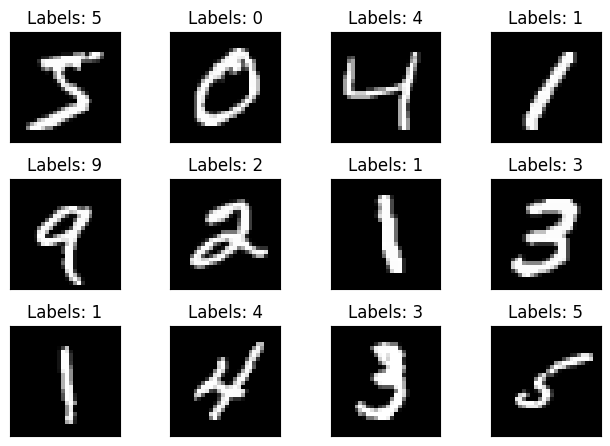

In [13]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(train_dataset.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

定义CNN模型

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),  #卷积
            torch.nn.ReLU(),  #ReLU激活
            torch.nn.MaxPool2d(kernel_size=2),  #最大池化
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),  #线性化
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 卷积+激活+池化
        x = self.conv2(x)  # 卷积+激活+池化
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

实例化模型

In [15]:
model = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

训练&测试

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001321
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.000141
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.003098
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.002840
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.005836
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.000321
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000427
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.000703
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000315
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.000053
Accuracy on test set: 98.86%
Best accuracy: 98.86% at epoch 1, model saved to best_model.ckpt
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000007
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001388
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003300
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.000102
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000347
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.012737
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.003292
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.000027
Train Epoch: 2 [51

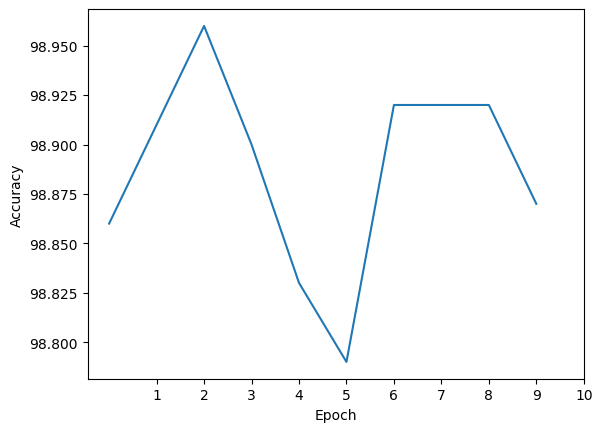

Best accuracy: 98.96% at epoch 3, model saved to best_model.ckpt


In [20]:
epochs = 10
acc_test_list = []  # 用于存储每个 epoch 的测试准确率
best_acc = 0.0  # 用于追踪最佳准确率
best_epoch = 0  # 用于追踪最佳epoch


def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 将数据和目标移动到 CUDA 设备
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test():
    global best_acc
    global best_epoch
    correct = 0
    total = 0
    with torch.no_grad():  # 在测试过程中禁用梯度计算
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 将数据和目标移动到 CUDA 设备
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    acc_test_list.append(accuracy)  # 在每个 epoch 结束后添加准确率
    print(f'Accuracy on test set: {accuracy}%')

    # 如果当前准确率是最佳的，保存模型
    if accuracy > best_acc:
        best_acc = accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.ckpt')
        print(f'Best accuracy: {best_acc}% at epoch {best_epoch}, model saved to best_model.ckpt')


for epoch in range(1, epochs + 1):
    train(epoch)
    test()

plt.plot(acc_test_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs + 1))
plt.show()
print(f'Best accuracy: {best_acc}% at epoch {best_epoch}, model saved to best_model.ckpt')